In [1]:
# automatic nested cross-validation of regression of 'Linear Regression using Step Forward Feature Selection' contrasted with 'Elastic Net' using pipelines as well as ZCA whitening to scale variables..

#https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
#https://machinelearningmastery.com/elastic-net-regression-in-python/
#https://github.com/rasbt/mlxtend/issues/41
#https://github.com/rasbt/mlxtend/issues/69
#https://stackoverflow.com/questions/53252156/standardscaler-with-pipelines-and-gridsearchcv

In [2]:
from abc import ABC, abstractmethod

import itertools

import matplotlib.pyplot as plt

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from numpy import arange
from numpy import mean
from numpy import std
import numpy as np

import os

import pandas as pd

from random import sample

import random

import re

#from sklearn.datasets import make_classification
from sklearn import linear_model
from sklearn.datasets import make_regression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    warnings.filterwarnings('ignore')

In [3]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# ------------------------------------
# file: zca.py
# date: Thu May 21 15:47 2015
# author:
# Maarten Versteegh
# github.com/mwv
# maartenversteegh AT gmail DOT com
#
# Licensed under GPLv3
# ------------------------------------
"""zca: ZCA whitening with a sklearn-like interface

"""

from __future__ import division

import numpy as np
from scipy import linalg

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, as_float_array

class ZCA(BaseEstimator, TransformerMixin):
    def __init__(self, regularization=1e-6, copy=False):
        self.regularization = regularization
        self.copy = copy

    def fit(self, X, y=None):
        """Compute the mean, whitening and dewhitening matrices.

        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data used to compute the mean, whitening and dewhitening
            matrices.
        """
        X = check_array(X, accept_sparse=None, copy=self.copy,
                        ensure_2d=True)
        X = as_float_array(X, copy=self.copy)
        self.mean_ = X.mean(axis=0)
        X_ = X - self.mean_
        cov = np.dot(X_.T, X_) / (X_.shape[0]-1)
        U, S, _ = linalg.svd(cov)
        s = np.sqrt(S.clip(self.regularization))
        s_inv = np.diag(1./s)
        s = np.diag(s)
        self.whiten_ = np.dot(np.dot(U, s_inv), U.T)
        self.dewhiten_ = np.dot(np.dot(U, s), U.T)
        return self

    def transform(self, X, y=None, copy=None):
        """Perform ZCA whitening

        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data to whiten along the features axis.
        """
        check_is_fitted(self, 'mean_')
        X = as_float_array(X, copy=self.copy)
        return np.dot(X - self.mean_, self.whiten_.T)

    def inverse_transform(self, X, copy=None):
        """Undo the ZCA transform and rotate back to the original
        representation

        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data to rotate back.
        """
        check_is_fitted(self, 'mean_')
        X = as_float_array(X, copy=self.copy)
        return np.dot(X, self.dewhiten_) + self.mean_


In [4]:
def read_data():
    df = pd.read_csv("https://raw.githubusercontent.com/thistleknot/Python-Stock/master/data/raw/states.csv").set_index('States')
    return(df)

In [5]:
independent = 'Poverty'
outer_k = 10
inner_k = 10
random_st = random.sample(list(np.arange(0,10,1)),1)[0]
print(random_st)

# configure the cross-validation procedure
cv_inner = KFold(n_splits=inner_k, shuffle=True, random_state=random_st)
cv_outer = KFold(n_splits=outer_k, shuffle=True, random_state=random_st)

5


In [6]:
# create dataset
y = read_data()[[independent]]
X = read_data()[(read_data().columns).difference([independent]).values]

In [7]:
scores = list()

In [8]:
model_results = list()

In [9]:
#elastic

cv = KFold(n_splits=10, random_state=1,shuffle=True)
ratios = arange(0, 1, 0.1)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)

outer_results = list()

# perform cross-validation procedure
for train_ix, test_ix in cv_outer.split(X):
    # split data
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

    
    pipe_ENet_Regressor = Pipeline([
                #('scaler',  ZCA()),
                ('ENet_Regressor', model)])

    grid_params_ENet_Regressor = [{
    }]

    CV_ENet_regressor = GridSearchCV (estimator = pipe_ENet_Regressor,
                                   param_grid = grid_params_ENet_Regressor,
                                   #cv = cv,return_train_score=True, verbose=0, refit=True)
                                   return_train_score=True, verbose=0, refit=True)

    CV_ENet_regressor.fit(X_train, y_train)
    
    
    best_model = CV_ENet_regressor.best_estimator_
    #ypred=CV_ENet_regressor.predict(X_test)
    yhat = best_model.predict(X_test)
    
    print(X.columns[best_model.named_steps['ENet_Regressor'].coef_!=0])
    
    # evaluate the model
    acc = mean_squared_error(y_test, yhat,squared=True)
    #cross_val_score(self.search, X, y, scoring='neg_mean_squared_error', cv=cv_outer, n_jobs=-1)
    # store the result
    outer_results.append(acc)
    
print('accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

model_results.append(['Elastic',mean(outer_results), std(outer_results)])

Index(['Crime', 'Doctors', 'Income', 'Infant Mort', 'Population',
       'Traf Deaths', 'Unemployed', 'University', 'White'],
      dtype='object')
Index(['Crime', 'Doctors', 'Income', 'Infant Mort', 'Population',
       'Traf Deaths', 'Unemployed', 'University', 'White'],
      dtype='object')
Index(['Crime', 'Doctors', 'Income', 'Population', 'White'], dtype='object')
Index(['Crime', 'Doctors', 'Income', 'Infant Mort', 'Population',
       'Traf Deaths', 'Unemployed', 'University', 'White'],
      dtype='object')
Index(['Crime', 'Doctors', 'Income', 'Infant Mort', 'Population',
       'Traf Deaths', 'Unemployed', 'University', 'White'],
      dtype='object')
Index(['Crime', 'Doctors', 'Income', 'Infant Mort', 'Population',
       'Traf Deaths', 'Unemployed', 'University', 'White'],
      dtype='object')
Index(['Crime', 'Doctors', 'Income', 'Population', 'White'], dtype='object')
Index(['Crime', 'Doctors', 'Income', 'Infant Mort', 'Population',
       'Traf Deaths', 'Unemployed', 'Uni

In [10]:
#linear

cv = KFold(n_splits=10, random_state=1,shuffle=True)
#model = ElasticNetCV(l1_ratio=0, alphas=[0], n_jobs=-1)
model = LinearRegression()

outer_results = list()

class sfs_(SFS):        
    def score(self):
        return np.min(np.abs([self.subsets_[i]['avg_score'] for i in range(1,len(self.subsets_))]))*-1

# perform cross-validation procedure
for train_ix, test_ix in cv_outer.split(X):
    # split data
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

    sfs1 = sfs_(model, 
               k_features=len(X.columns),
               forward=True, 
               floating=False, 
               scoring='neg_mean_squared_error',
               cv=cv)

    pipe = Pipeline([
                    #('standardize', ZCA()),
                     ('sfs', sfs1)#, 
                     #('lr', model)
                    ])

    param_grid = {
      }

    CV_Linear_regressor = GridSearchCV (estimator = pipe,
                                   param_grid = param_grid,
                                   #cv = cv,return_train_score=True, verbose=0, refit=True)
                                   verbose=0, refit=True)

    CV_Linear_regressor.fit(X_train, y_train)
    
    #ypred=CV_ENet_regressor.predict(X_test)

    best_model = CV_Linear_regressor.best_estimator_
    #plt.plot(pd.DataFrame(best_model.named_steps['sfs'].subsets_).loc['avg_score'])

    bestSFS=X.columns[pd.Series(pd.DataFrame(best_model.named_steps['sfs'].subsets_).iloc[:,np.argmin(np.abs(pd.DataFrame(best_model.named_steps['sfs'].subsets_).loc['avg_score']))-1].feature_idx).to_list()]
    print(bestSFS)
    lm = LinearRegression()
    lm.fit(X_train[bestSFS],y_train)
    
    #print(best_model.named_steps['lr'].coef_)
    yhat = lm.predict(X_test[bestSFS])

    # evaluate the model
    acc = mean_squared_error(y_test, yhat,squared=True)
    #cross_val_score(self.search, X, y, scoring='neg_mean_squared_error', cv=cv_outer, n_jobs=-1)
    # store the result
    outer_results.append(acc)
    
print('accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

model_results.append(['Linear',mean(outer_results), std(outer_results)])

Index(['Income', 'Population', 'Unemployed', 'White'], dtype='object')
Index(['Income', 'Population', 'Traf Deaths', 'Unemployed', 'White'], dtype='object')
Index(['Crime', 'Doctors', 'Income', 'Traf Deaths'], dtype='object')
Index(['Income', 'Population', 'Traf Deaths', 'Unemployed', 'White'], dtype='object')
Index(['Income', 'Infant Mort', 'Unemployed', 'White'], dtype='object')
Index(['Income', 'Population', 'Unemployed', 'White'], dtype='object')
Index(['Income', 'Population', 'Traf Deaths', 'Unemployed', 'White'], dtype='object')
Index(['Income', 'Population', 'Traf Deaths', 'Unemployed', 'White'], dtype='object')
Index(['Income', 'Population', 'Traf Deaths', 'Unemployed', 'White'], dtype='object')
Index(['Income', 'Population', 'Traf Deaths', 'Unemployed', 'White'], dtype='object')
accuracy: 2.849 (2.673)


In [11]:
for s in range(0,len(model_results)):
    print('Model: ', model_results[s][0])
    print('Accuracy: %.3f (%.3f)' % (model_results[s][1], model_results[s][2]))

#step 1: An algorithm is selected based on its performance on the outer loop of nested cross-validation.
best_model = [item[0] for item in model_results][np.argmin(np.abs([item[1] for item in model_results]))]
print(best_model)

Model:  Elastic
Accuracy: 2.555 (2.068)
Model:  Linear
Accuracy: 2.849 (2.673)
Elastic


Linear
Index(['Income', 'Population', 'Traf Deaths', 'Unemployed', 'White'], dtype='object')


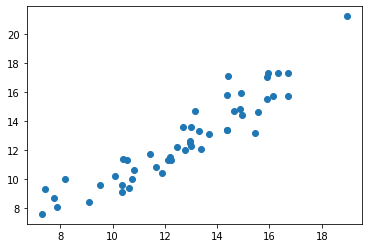

1.115266743000655
Elastic
Index(['Crime', 'Doctors', 'Income', 'Infant Mort', 'Population',
       'Traf Deaths', 'Unemployed', 'University', 'White'],
      dtype='object')
alpha:  100.0
lr_ratio:  0.0


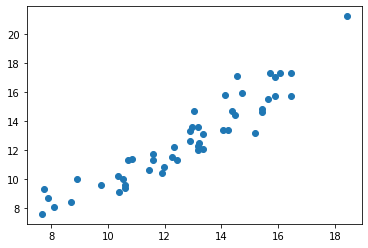

1.1024558565598044


In [12]:
#best_model='Elastic'
#if(best_model=='Linear'):
if(True):
    print('Linear')
    #Step 2: inner-procedure is applied to the entire dataset.
    
    sfs1 = sfs_(model, 
               k_features=len(X.columns),
               forward=True, 
               floating=False, 
               scoring='neg_mean_squared_error',
               cv=cv)
    
    pipe = Pipeline([
                    #('standardize', ZCA()),
                     ('sfs', sfs1)#, 
                     #('lr', model)
                    ])

    param_grid = {
      }
    
    ratios = arange(0, 1, 0.1)
    alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
    model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)

    CV_Linear_regressor = GridSearchCV (estimator = pipe,
                                   param_grid = param_grid,
                                   #cv = cv,return_train_score=True, verbose=0, refit=True)
                                   verbose=0, refit=True)

    CV_Linear_regressor.fit(X, y)
    
    #ypred=CV_ENet_regressor.predict(X_test)

    #step 3: hyperparameters found during this final search are then used to configure a final model.
    
    best_model = CV_Linear_regressor.best_estimator_
    #plt.plot(pd.DataFrame(best_model.named_steps['sfs'].subsets_).loc['avg_score'])

    bestSFS=X.columns[pd.Series(pd.DataFrame(best_model.named_steps['sfs'].subsets_).iloc[:,np.argmin(np.abs(pd.DataFrame(best_model.named_steps['sfs'].subsets_).loc['avg_score']))-1].feature_idx).to_list()]
    print(bestSFS)
    lm = LinearRegression()
    
    #step 4: final model is fit on the entire dataset.
    zca = ZCA()
    final_model = lm.fit(pd.DataFrame(zca.fit_transform(X[bestSFS]),columns=bestSFS).set_index(y.index),y)
    
    plt.scatter(final_model.predict(pd.DataFrame(zca.fit_transform(X[bestSFS]),columns=bestSFS).set_index(y.index)),y)
    plt.show()
    print(mean_squared_error(y, final_model.predict(pd.DataFrame(zca.fit_transform(X[bestSFS]),columns=bestSFS).set_index(y.index)), squared=True))
        
#elif(best_model=='Elastic'):
if(True):
    print('Elastic')
    #Step 2: inner-procedure is applied to the entire dataset.
    
    pipe_ENet_Regressor = Pipeline([
                #('scaler',  ZCA()),
                ('ENet_Regressor', model)])

    grid_params_ENet_Regressor = [{
    }]

    CV_ENet_regressor = GridSearchCV (estimator = pipe_ENet_Regressor,
                                   param_grid = grid_params_ENet_Regressor,
                                   #cv = cv,return_train_score=True, verbose=0, refit=True)
                                   return_train_score=True, verbose=0, refit=True)

    CV_ENet_regressor.fit(X, y)
    #step 3: hyperparameters found during this final search are then used to configure a final model.
    
    zca = ZCA()
    
    best_model = CV_ENet_regressor.best_estimator_
    
    #have to re-derive alphas and lambda's based on ZCA
    #best_model.named_steps['ENet_Regressor'].coef_
    filtered = X.columns[best_model.named_steps['ENet_Regressor'].coef_.ravel()!=0]
    print(filtered)
    print('alpha: ',best_model.named_steps['ENet_Regressor'].alpha_)
    print('lr_ratio: ',best_model.named_steps['ENet_Regressor'].l1_ratio_)
    
    #step 4: The final model is fit on the entire dataset.
    CV_ENet_regressor.fit(pd.DataFrame(zca.fit_transform(X[filtered]),columns=filtered).set_index(y.index), y)
    best_model = CV_ENet_regressor.best_estimator_
    
    #ypred=CV_ENet_regressor.predict(X_test)
    yhat = best_model.predict(pd.DataFrame(zca.fit_transform(X[filtered]),columns=filtered).set_index(y.index))
    
    # evaluate the model
    acc = mean_squared_error(y, yhat,squared=True)
    
    #final_model.fit(zca.transform(X),y)    
    
    #step 4: final model is fit on the entire dataset.
    plt.scatter(best_model.predict(zca.transform(X[filtered])),y)
    plt.show()
    print(mean_squared_error(y, best_model.predict(pd.DataFrame(zca.fit_transform(X[filtered]),columns=filtered).set_index(y.index)), squared=True))
